##### Piyush Ranade
##### 3/9/2022
##### Kenpom-based NCAA March Madness Prediction Modeling 2022

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
    GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import scipy
from scipy.stats import uniform, loguniform
import lightgbm
from lightgbm import LGBMClassifier
import sklearn.metrics
pd.set_option('display.max_columns', None)
import collections
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import datetime
import dateutil.parser
import sys
import warnings
warnings.filterwarnings('ignore')
print(datetime.datetime.now())

2022-05-10 09:46:50.405531


In [2]:
# set seed for reproducibility
RANDOMSTATE = 43
np.random.seed(RANDOMSTATE)

In [3]:
def assign_round(df):
    df['Round'] = 'PlayIn'
    for i in range(len(df)):
        if df['Season'][i]<2021:
            if df['DayNum'][i]==154:
                df['Round'][i] = 'Champ'
            elif df['DayNum'][i]==152:
                df['Round'][i] = 'Final4'
            elif df['DayNum'][i] in [145,146]:
                df['Round'][i] = 'Elite8'
            elif df['DayNum'][i] in [143,144]:
                df['Round'][i] = 'Sweet16'
            elif df['DayNum'][i] in [138,139]:
                df['Round'][i] = 'Round2'
            elif df['DayNum'][i] in [136,137]:
                df['Round'][i] = 'Round1'
        elif df['Season'][i]==2021:
            if df['DayNum'][i]==154:
                df['Round'][i] = 'Champ'
            elif df['DayNum'][i]==152:
                df['Round'][i] = 'Final4'
            elif df['DayNum'][i] in [147,148]:
                df['Round'][i] = 'Elite8'
            elif df['DayNum'][i] in [145,146]:
                df['Round'][i] = 'Sweet16'
            elif df['DayNum'][i] in [139,140]:
                df['Round'][i] = 'Round2'
            elif df['DayNum'][i] in [137,138]:
                df['Round'][i] = 'Round1'
    return df

### Create Training Set

In [4]:
R = pd.read_csv("MNCAATourneyCompactResults.csv")
D = pd.read_csv("NCAA2021_Kenpom.csv")
C = pd.read_csv("MTeamCoaches.csv")

In [5]:
D2 = D.drop(['TeamName','FirstD1Season','LastD1Season','Seed','record'],axis=1)

In [6]:
C2 = C.drop(['FirstDayNum','LastDayNum'],axis=1)

In [7]:
R2 = assign_round(R)
R3 = R2.drop(['DayNum','WScore','LScore','WLoc','NumOT'],axis=1)
R4 = R3.merge(C2,how='inner',left_on=['Season','WTeamID'],right_on=['Season','TeamID']).drop(columns = ['TeamID']).rename(columns={"CoachName": "WCoachName"})
R5 = R4.merge(C2,how='inner',left_on=['Season','LTeamID'],right_on=['Season','TeamID']).drop(columns = ['TeamID']).rename(columns={"CoachName": "LCoachName"})
R5_1 = R5.loc[R5['WinFirst'] == 1].reset_index(drop=True)
R5_2 = R5.loc[R5['WinFirst'] == 0].reset_index(drop=True)
R6_1 = R5_1.merge(D2,how='inner',left_on=['Season','WTeamID'],right_on=['Season','TeamID'])
R7_1 = R6_1.merge(D2,how='inner',left_on=['Season','LTeamID'],right_on=['Season','TeamID'],suffixes=('', '_opp')).rename(columns={"WCoachName": "CoachName", "LCoachName": "CoachName_opp"})
R7_1['Result'] = 1
R6_2 = R5_2.merge(D2,how='inner',left_on=['Season','LTeamID'],right_on=['Season','TeamID'])
R7_2 = R6_2.merge(D2,how='inner',left_on=['Season','WTeamID'],right_on=['Season','TeamID'],suffixes=('', '_opp')).rename(columns={"WCoachName": "CoachName_opp", "LCoachName": "CoachName"})
R7_2['Result'] = 0
R8 = pd.concat([R7_1,R7_2])
RF = R8.drop(['Season','WTeamID','LTeamID','WinFirst','TeamID','TeamID_opp','team','team_opp'],axis=1)
RF.columns= RF.columns.str.upper()
RF = RF.sort_index(axis=1)
RF = RF.dropna(axis=0)
RF = RF.sample(frac=1,random_state=RANDOMSTATE).reset_index(drop=True)
for c in RF.columns:
    col_type = RF[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        RF[c] = RF[c].astype('category')
RF.head()

,ADJ_D,ADJ_D_OPP,ADJ_D_RANK,ADJ_D_RANK_OPP,ADJ_EM,ADJ_EM_OPP,ADJ_O,ADJ_O_OPP,ADJ_O_RANK,ADJ_O_RANK_OPP,ADJ_TEMPO,ADJ_TEMPO_OPP,ADJ_TEMPO_RANK,ADJ_TEMPO_RANK_OPP,COACHNAME,COACHNAME_OPP,CONFERENCE,CONFERENCE_OPP,LUCK,LUCK_OPP,LUCK_RANK,LUCK_RANK_OPP,NCAA_SEED,NCAA_SEED_OPP,NC_SOS_ADJ_EM,NC_SOS_ADJ_EM_OPP,NC_SOS_ADJ_EM_RANK,NC_SOS_ADJ_EM_RANK_OPP,RANK,RANK_OPP,RESULT,ROUND,SOS_ADJ_D,SOS_ADJ_D_OPP,SOS_ADJ_D_RANK,SOS_ADJ_D_RANK_OPP,SOS_ADJ_EM,SOS_ADJ_EM_OPP,SOS_ADJ_EM_RANK,SOS_ADJ_EM_RANK_OPP,SOS_ADJ_O,SOS_ADJ_O_OPP,SOS_ADJ_O_RANK,SOS_ADJ_O_RANK_OPP
0,90.7,93.0,11,25,23.83,10.23,114.5,103.3,23,156,67.2,64.5,93,210,bill_self,brian_gregory,B12,A10,-0.013,0.107,202,5,3.0,11.0,1.55,-4.57,117,269,14,78,1,Round2,99.1,102.6,39,152,8.83,2.34,37,110,107.9,104.9,32,93
1,98.5,91.1,78,8,13.49,24.79,112.0,115.9,47,18,65.6,66.0,156,136,shaka_smart,matt_painter,CAA,B10,0.021,0.007,128,161,11.0,3.0,2.26,1.21,89,120,53,9,1,Round2,101.0,98.7,75,12,4.79,10.16,70,14,105.8,108.8,74,18
2,97.8,91.9,67,15,19.65,23.93,117.4,115.8,12,19,65.3,64.5,170,221,sean_miller,jim_calhoun,P10,BE,0.064,0.048,32,58,5.0,3.0,-0.36,-0.77,166,179,20,10,0,Elite8,100.0,97.4,41,2,7.69,12.78,34,2,107.7,110.1,30,8
3,96.4,102.3,57,151,-0.68,-10.40,95.8,91.9,278,314,64.6,68.5,202,55,dave_calloway,bobby_collins,NEC,MEAC,0.018,-0.057,120,289,16.0,16.0,4.12,-8.98,58,321,164,271,1,PlayIn,104.7,107.6,215,322,-3.55,-14.27,221,334,101.2,93.3,235,334
4,95.6,89.5,33,7,16.51,14.89,112.1,104.3,44,177,65.0,68.4,309,136,johnny_dawkins,mike_rhoades,Amer,A10,0.011,0.007,152,164,9.0,8.0,-3.71,3.60,264,67,34,42,1,Round1,100.9,103.8,57,123,4.99,1.37,69,105,105.9,105.2,90,120


In [9]:
responses = np.array(['RESULT'])
predictors=np.array(RF.columns[RF.columns != 'RESULT'])
print(responses)
print(predictors)

['RESULT']
['ADJ_D' 'ADJ_D_OPP' 'ADJ_D_RANK' 'ADJ_D_RANK_OPP' 'ADJ_EM' 'ADJ_EM_OPP'
 'ADJ_O' 'ADJ_O_OPP' 'ADJ_O_RANK' 'ADJ_O_RANK_OPP' 'ADJ_TEMPO'
 'ADJ_TEMPO_OPP' 'ADJ_TEMPO_RANK' 'ADJ_TEMPO_RANK_OPP' 'COACHNAME'
 'COACHNAME_OPP' 'CONFERENCE' 'CONFERENCE_OPP' 'LUCK' 'LUCK_OPP'
 'LUCK_RANK' 'LUCK_RANK_OPP' 'NCAA_SEED' 'NCAA_SEED_OPP' 'NC_SOS_ADJ_EM'
 'NC_SOS_ADJ_EM_OPP' 'NC_SOS_ADJ_EM_RANK' 'NC_SOS_ADJ_EM_RANK_OPP' 'RANK'
 'RANK_OPP' 'ROUND' 'SOS_ADJ_D' 'SOS_ADJ_D_OPP' 'SOS_ADJ_D_RANK'
 'SOS_ADJ_D_RANK_OPP' 'SOS_ADJ_EM' 'SOS_ADJ_EM_OPP' 'SOS_ADJ_EM_RANK'
 'SOS_ADJ_EM_RANK_OPP' 'SOS_ADJ_O' 'SOS_ADJ_O_OPP' 'SOS_ADJ_O_RANK'
 'SOS_ADJ_O_RANK_OPP']


### Model Training!

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

In [11]:
# Split into train/test
dftrain, dftest = train_test_split(RF,test_size=0.2,random_state=7,stratify=RF['RESULT'])

In [12]:
print(dftrain.shape)
dftrain.isnull().sum().sum()

(995, 44)


0

In [13]:
print(dftest.shape)
dftest.isnull().sum().sum()

(249, 44)


0

In [14]:
# always use same k-folds for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOMSTATE)
kf.get_n_splits(dftrain)

5

### LightGBM with Categorical Features!

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm
from lightgbm import LGBMClassifier

In [16]:
# COARSE SPACE
space = {'num_leaves': hp.uniformint('num_leaves',5, 20),
         'reg_alpha': hp.quniform('reg_alpha',0,0.25,0.001),
         'learning_rate': hp.quniform('learning_rate',0.05, 0.2, 0.001),
         'subsample': hp.quniform('subsample',0.75, 1, 0.01),
         'n_estimators': hp.uniformint('n_estimators',300,1000),
         'colsample_bytree': hp.quniform('colsample_bytree',0.75, 1, 0.01),
         'min_child_samples': hp.uniformint('min_child_samples',2,20),
         'max_depth': hp.uniformint('max_depth',6,12)}

In [17]:
def objectivelgbm(space):
    lgbm = LGBMClassifier(objective='binary',
                     verbose=-1,
                     n_jobs=-1,
                     boosting_type = 'goss',
                     random_state=RANDOMSTATE,
                     n_estimators=space['n_estimators'],
                     max_depth=space['max_depth'],
                     subsample=space['subsample'],
                     reg_alpha=space['reg_alpha'],
                     num_leaves=space['num_leaves'],
                     learning_rate=space['learning_rate'],
                     min_child_samples=space['min_child_samples'],
                     colsample_bytree=space['colsample_bytree'])
    lgbmscores = -cross_val_score(lgbm, dftrain[predictors], dftrain[responses],
                          scoring='f1',
                          cv=kf)
    accuracy_met = np.mean(lgbmscores)
    return {'loss': accuracy_met, 'status': STATUS_OK}

In [18]:
trials = Trials()

print("Time: ",datetime.datetime.now())
best_hyperparams = fmin(fn = objectivelgbm,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 250,
                        trials = trials)
print("Time: ",datetime.datetime.now())
print(best_hyperparams)
print(predictors)

Time:  2022-05-10 09:47:55.010864
100%|█████████████████████████████████████████████| 250/250 [03:01<00:00,  1.38trial/s, best loss: -0.7738719919867005]
Time:  2022-05-10 09:50:56.029309
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.052000000000000005, 'max_depth': 10.0, 'min_child_samples': 19.0, 'n_estimators': 393.0, 'num_leaves': 7.0, 'reg_alpha': 0.213, 'subsample': 0.76}
['ADJ_D' 'ADJ_D_OPP' 'ADJ_D_RANK' 'ADJ_D_RANK_OPP' 'ADJ_EM' 'ADJ_EM_OPP'
 'ADJ_O' 'ADJ_O_OPP' 'ADJ_O_RANK' 'ADJ_O_RANK_OPP' 'ADJ_TEMPO'
 'ADJ_TEMPO_OPP' 'ADJ_TEMPO_RANK' 'ADJ_TEMPO_RANK_OPP' 'COACHNAME'
 'COACHNAME_OPP' 'CONFERENCE' 'CONFERENCE_OPP' 'LUCK' 'LUCK_OPP'
 'LUCK_RANK' 'LUCK_RANK_OPP' 'NCAA_SEED' 'NCAA_SEED_OPP' 'NC_SOS_ADJ_EM'
 'NC_SOS_ADJ_EM_OPP' 'NC_SOS_ADJ_EM_RANK' 'NC_SOS_ADJ_EM_RANK_OPP' 'RANK'
 'RANK_OPP' 'ROUND' 'SOS_ADJ_D' 'SOS_ADJ_D_OPP' 'SOS_ADJ_D_RANK'
 'SOS_ADJ_D_RANK_OPP' 'SOS_ADJ_EM' 'SOS_ADJ_EM_OPP' 'SOS_ADJ_EM_RANK'
 'SOS_ADJ_EM_RANK_OPP' 'SOS_ADJ_O' 'SOS_ADJ_O_OPP' 'SOS

In [19]:
print(best_hyperparams)

{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.052000000000000005, 'max_depth': 10.0, 'min_child_samples': 19.0, 'n_estimators': 393.0, 'num_leaves': 7.0, 'reg_alpha': 0.213, 'subsample': 0.76}


In [20]:
results_df = pd.concat([pd.DataFrame(trials.vals), pd.DataFrame(trials.results)], axis=1).reset_index(drop=True)
results_df.head()

,colsample_bytree,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,reg_alpha,subsample,loss,status
0,0.99,0.085,6.0,7.0,397.0,16.0,0.079,0.89,-0.760640,ok
1,0.86,0.172,7.0,17.0,717.0,13.0,0.091,0.93,-0.761518,ok
2,0.83,0.197,11.0,4.0,966.0,18.0,0.246,0.91,-0.746874,ok
3,0.76,0.142,11.0,15.0,368.0,16.0,0.071,0.77,-0.750467,ok
4,0.91,0.137,11.0,4.0,693.0,17.0,0.141,0.93,-0.761098,ok


In [21]:
T7 = results_df.sort_values(by=['loss']).head(n=7).reset_index(drop=True)
T7

,colsample_bytree,learning_rate,max_depth,min_child_samples,n_estimators,num_leaves,reg_alpha,subsample,loss,status
0,0.95,0.052,10.0,19.0,393.0,7.0,0.213,0.76,-0.773872,ok
1,0.96,0.165,9.0,10.0,373.0,6.0,0.155,0.89,-0.772786,ok
2,0.96,0.162,9.0,15.0,390.0,13.0,0.068,0.94,-0.771962,ok
3,0.98,0.131,8.0,17.0,831.0,13.0,0.152,0.86,-0.771483,ok
4,1.00,0.052,9.0,16.0,493.0,9.0,0.212,0.97,-0.770253,ok
5,0.92,0.200,9.0,7.0,812.0,14.0,0.055,0.86,-0.769986,ok
6,0.97,0.131,10.0,13.0,365.0,11.0,0.191,0.97,-0.769852,ok


### Fit the Model

In [22]:
dffit, dfval = train_test_split(dftrain, test_size=0.1, random_state=41)

In [23]:
def fit_model(i):
    lgbm = LGBMClassifier(objective='binary',
                 verbose=-1,
                 n_jobs=-1,
                 random_state=RANDOMSTATE,
                 n_estimators=10000,
                 max_depth=int(T7['max_depth'][i]),
                 subsample=T7['subsample'][i],
                 reg_alpha=T7['reg_alpha'][i],
                 num_leaves=int(T7['num_leaves'][i]),
                 learning_rate=T7['learning_rate'][i],
                 min_child_samples=int(T7['min_child_samples'][i]),
                 colsample_bytree=T7['colsample_bytree'][i])
    lgbm.fit(dffit[predictors],dffit[responses],
        eval_set=[(dfval[predictors],dfval[responses])],
        eval_metric='l2',
        verbose=-1,
        early_stopping_rounds=150,
        categorical_feature='auto')
    ypred=lgbm.predict(dftest[predictors])
    print(sklearn.metrics.accuracy_score(dftest[responses], ypred))
    return lgbm

In [24]:
model0 = fit_model(0)
model1 = fit_model(1)
model2 = fit_model(2)
model3 = fit_model(3)
model4 = fit_model(4)
model5 = fit_model(5)
model6 = fit_model(6)

0.7309236947791165
0.7630522088353414
0.7429718875502008
0.7269076305220884
0.7269076305220884
0.7550200803212851
0.7550200803212851


In [31]:
from pickle import dump
# save the model
dump(model0, open('model0_051022.pkl', 'wb'))
dump(model1, open('model1_051022.pkl', 'wb'))
dump(model2, open('model2_051022.pkl', 'wb'))
dump(model3, open('model3_051022.pkl', 'wb'))
dump(model4, open('model4_051022.pkl', 'wb'))
dump(model5, open('model5_051022.pkl', 'wb'))
dump(model6, open('model6_051022.pkl', 'wb'))

### Create 2022 Data for Prediction

In [26]:
DN = pd.read_csv("kenpom_2022.csv")
CN = pd.read_csv("MTeamCoaches_2022.csv")

In [27]:
DN2 = DN.merge(CN,how='inner',left_on=['TeamID'],right_on=['TeamID'])
DN2.columns= DN2.columns.str.upper()
DN2 = DN2.sort_index(axis=1)
for c in DN2.columns:
    col_type = DN2[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        DN2[c] = DN2[c].astype('category')
DN2 = DN2.drop_duplicates(subset=['TEAMID'],keep='first')
DN2.head()

,ADJ_D,ADJ_D_RANK,ADJ_EM,ADJ_O,ADJ_O_RANK,ADJ_TEMPO,ADJ_TEMPO_RANK,COACHNAME,CONFERENCE,FIRSTDAYNUM,LASTDAYNUM,LUCK,LUCK_RANK,NCAA_SEED,NC_SOS_ADJ_EM,NC_SOS_ADJ_EM_RANK,RANK,SEASON,SOS_ADJ_D,SOS_ADJ_D_RANK,SOS_ADJ_EM,SOS_ADJ_EM_RANK,SOS_ADJ_O,SOS_ADJ_O_RANK,TEAM,TEAMID,W-L
0,102.7,166,3.49,106.2,113,62.1,351,john_groce,MAC,0,154,0.026,119,13,-4.18,286,131,2022,106.0,288,-5.24,280,100.8,264,Akron,1103,24-9
1,98.7,94,17.36,116.1,14,71.7,12,nate_oats,SEC,0,154,-0.022,226,6,10.22,11,25,2022,96.9,7,12.79,1,109.7,3,Alabama,1104,19-13
2,92.4,20,27.21,119.6,5,72.2,8,tommy_lloyd,P12,0,154,0.046,77,1,-0.22,170,2,2022,99.7,57,6.34,67,106.0,75,Arizona,1112,31-3
3,92.1,16,19.02,111.1,40,70.6,28,eric_musselman,SEC,0,154,0.027,117,4,-2.79,251,20,2022,98.9,35,7.93,46,106.8,56,Arkansas,1116,25-8
4,89.1,8,24.45,113.6,24,70.0,40,bruce_pearl,SEC,0,154,-0.039,271,2,4.16,58,10,2022,98.5,26,8.77,34,107.2,44,Auburn,1120,27-5


### Make Predictions!

In [33]:
# load the model from disk
import pickle
# LR0 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/CESMII-STP/Modeling/baseline_LR.pkl', "rb"))
model0 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model0_051022.pkl', "rb"))
model1 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model1_051022.pkl', "rb"))
model2 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model2_051022.pkl', "rb"))
model3 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model3_051022.pkl', "rb"))
model4 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model4_051022.pkl', "rb"))
model5 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model5_051022.pkl', "rb"))
model6 = pickle.load(open('C:/Users/H195242/Documents/AERO-PROGRAMS/Random/MM2022/model6_051022.pkl', "rb"))

In [42]:
pick_winner(1242,1211,'Champ')

Winner:  Gonzaga 
Decision: Split 
 Kansas ( 0.30479286034317676 ) 
 Gonzaga ( 0.4403109567603463 )


### Feature Importance

Text(0.5, 0, 'LGBM Feature Importance')

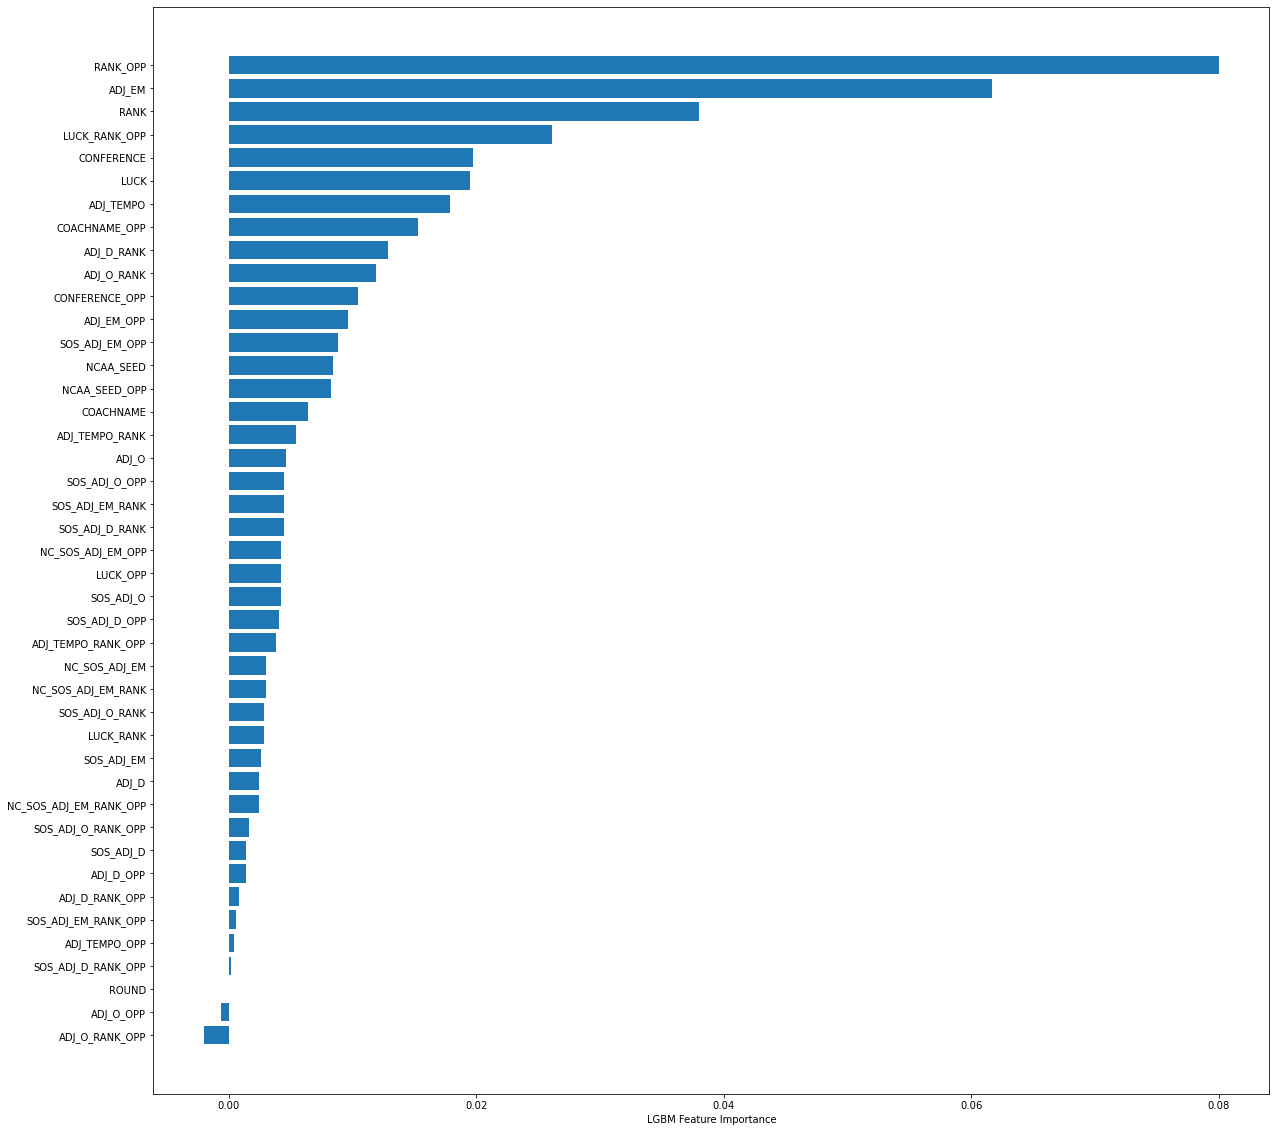

In [35]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
# Get permutation importance 
feature_importance = permutation_importance(model0, dftrain[predictors], dftrain[responses])
#print(feature_importance['importances_mean'])
plt.figure(figsize=(20,20))
sorted_idx = feature_importance['importances_mean'].argsort()
plt.barh(predictors[sorted_idx], feature_importance['importances_mean'][sorted_idx])
plt.xlabel("LGBM Feature Importance")

### Local Functions

In [36]:
def get_row(tn1,tn2,D,predictors,rd):
    row1df = D[(D['TEAMID'] == tn1)]
    row1df['ROUND'] = rd
    row2df = D[(D['TEAMID'] == tn2)]
    row2df.columns = row2df.columns+'_OPP'
    finalRow=pd.concat([row1df, row2df.set_index(row1df.index)], axis=1)
    finalRow = finalRow[predictors]
    finalRow['ROUND'] = finalRow['ROUND'].astype('category')
    return finalRow

In [37]:
def pick_winner(t1,t2,rd):
    dfnew1 = get_row(t1,t2,DN2,predictors,rd)
    dfnew2 = get_row(t2,t1,DN2,predictors,rd)

    ypreds1 = []
    ypreds1.append(model_predict(model0,dfnew1))
    ypreds1.append(model_predict(model1,dfnew1))
    ypreds1.append(model_predict(model2,dfnew1))
    ypreds1.append(model_predict(model3,dfnew1))
    ypreds1.append(model_predict(model4,dfnew1))
    ypreds1.append(model_predict(model5,dfnew1))
    ypreds1.append(model_predict(model6,dfnew1))
    d1 = pd.DataFrame(ypreds1,columns=['Win','Prob'])
    decision1 = d1['Win'].sum()
    probsum1 = d1['Prob'].sum()
    t1_winprob = probsum1[0][1]/7

    if decision1[0]>3:
        winner1 = t1
    else:
        winner1 = t2

    ypreds2 = []
    ypreds2.append(model_predict(model0,dfnew2))
    ypreds2.append(model_predict(model1,dfnew2))
    ypreds2.append(model_predict(model2,dfnew2))
    ypreds2.append(model_predict(model3,dfnew2))
    ypreds2.append(model_predict(model4,dfnew2))
    ypreds2.append(model_predict(model5,dfnew2))
    ypreds2.append(model_predict(model6,dfnew2))
    d2 = pd.DataFrame(ypreds2,columns=['Win','Prob'])
    decision2 = d2['Win'].sum()
    probsum2 = d2['Prob'].sum()
    t2_winprob = probsum2[0][1]/7
    if decision2[0]>3:
        winner2 = t2
    else:
        winner2 = t1

    if winner1==winner2:
        winner = winner1
        print('Winner: ',list(DN2['TEAM'][DN2['TEAMID'] == winner])[0],'\nDecision: Unanimous')
    else:
        if t1_winprob>t2_winprob:
            winner = t1
        else:
            winner = t2
        print('Winner: ',list(DN2['TEAM'][DN2['TEAMID'] == winner])[0],'\nDecision: Split', '\n',
              list(DN2['TEAM'][DN2['TEAMID'] == t1])[0],'(',t1_winprob,')','\n',
              list(DN2['TEAM'][DN2['TEAMID'] == t2])[0],'(',t2_winprob,')')

In [ ]:
def model_predict(model,row):
    ypred=model.predict(row)
    ypredprob=model.predict_proba(row)
    return ypred,ypredprob